## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras.layers import Activation, PReLU
from tensorflow.keras.layers import Embedding, Reshape
from tensorflow.keras.layers import Dense, Dropout, Input

## Load autoencoder model

In [2]:
autoencoder = load_model('../input/customer-churn-rate-dae/DAE_model.h5')
feature_model = Model(inputs=autoencoder.input,
                      outputs=autoencoder.get_layer('Embedding').output)
feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, 142)]        0                                            
__________________________________________________________________________________________________
Encoder-Dense-1 (Dense)         (None, 128)          18304       Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-BatchNorm-1 (BatchNorma (None, 128)          512         Encoder-Dense-1[0][0]            
__________________________________________________________________________________________________
Encoder-Swish-1 (Activation)    (None, 128)          0           Encoder-BatchNorm-1[0][0]        
______________________________________________________________________________________________

## Prepare data for model training

In [3]:
with open("../input/customer-churn-rate-preprocess-data/Churn_Risk_Rate_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

42

In [4]:
cat_cols = ['region_category','membership_category','preferred_offer_types','internet_option',
            'complaint_status','feedback','age_category','joining_dt_year','time_category',
            'complaint_category','feedback_category','last_login_category']

train_df1, test_df1 = train_df.copy(), test_df.copy()

for col in cat_cols:
    dummy_val = pd.get_dummies(train_df1[col], prefix='col')
    train_df1 = pd.concat([train_df1, dummy_val], axis=1)
    train_df1.drop([col], inplace=True, axis=1)

print("train_df1: {}".format(train_df1.shape))

for col in cat_cols:
    dummy_val = pd.get_dummies(test_df1[col], prefix='col')
    test_df1 = pd.concat([test_df1, dummy_val], axis=1)
    test_df1.drop([col], inplace=True, axis=1)

print("test_df1: {}".format(test_df1.shape))

train_df1: (36987, 143)
test_df1: (19919, 142)


In [5]:
Xtrain_embed = feature_model.predict(train_df1.loc[:, train_df1.columns != 'churn_risk_score'].values)
Xtest_embed = feature_model.predict(test_df1.values)
Xtrain_embed_df = pd.DataFrame(Xtrain_embed, index=train_df1.index)
Xtest_embed_df = pd.DataFrame(Xtest_embed, index=test_df1.index)
print("Xtrain_embed_df: {} \nXtest_embed_df: {}".format(Xtrain_embed_df.shape, Xtest_embed_df.shape))

train_df = pd.merge(train_df, Xtrain_embed_df, on='customer_id', sort=False)
test_df = pd.merge(test_df, Xtest_embed_df, on='customer_id', sort=False)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

del Xtrain_embed
del Xtest_embed
del Xtrain_embed_df
del Xtest_embed_df
gc.collect()

Xtrain_embed_df: (36987, 64) 
Xtest_embed_df: (19919, 64)
train_df: (36987, 170) 
test_df: (19919, 169)


1393

In [6]:
train_df['churn_risk_score'] = train_df['churn_risk_score'].apply(lambda x: 0 if x==5 else 1 if x==-1 else x)
train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})

,churn_risk_score,count
0,0,9825
1,1,3815
2,2,2741
3,3,10422
4,4,10184


In [7]:
cat_cols = ['gender','joined_through_referral','used_special_discount','offer_application_preference',
            'past_complaint','joining_dt_day_weekend','referral_id_present','has_desktop','has_smartphone',
            'region_category','membership_category','preferred_offer_types','internet_option','complaint_status',
            'feedback','age_category','joining_dt_year','time_category','complaint_category','feedback_category',
            'last_login_category']

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)

In [8]:
train_df['joining_dt_year'] = train_df['joining_dt_year'].apply(lambda x: 0 if x==2015 else 1 if x==2016 else 2)
test_df['joining_dt_year'] = test_df['joining_dt_year'].apply(lambda x: 0 if x==2015 else 1 if x==2016 else 2)

In [9]:
temp_df = train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['churn_risk_score', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.2789821882951654,
 1: 0.7184796854521627,
 2: 1.0,
 3: 0.26300134331222413,
 4: 0.2691476826394344}

In [10]:
vocab_size1 = train_df['region_category'].nunique()
vocab_size2 = train_df['membership_category'].nunique()
vocab_size3 = train_df['preferred_offer_types'].nunique()
vocab_size4 = train_df['has_desktop'].nunique()
vocab_size5 = train_df['internet_option'].nunique()
vocab_size6 = train_df['complaint_status'].nunique()
vocab_size7 = train_df['feedback'].nunique()
vocab_size8 = train_df['age_category'].nunique()
#vocab_size9 = train_df['joining_dt_year'].nunique()
vocab_size10 = train_df['time_category'].nunique()
vocab_size11 = train_df['last_login_category'].nunique()
vocab_size12 = train_df['complaint_category'].nunique()
vocab_size13 = train_df['feedback_category'].nunique()
vocab_size14 = train_df['has_smartphone'].nunique()

vocab_list = [vocab_size1, vocab_size2, vocab_size3, vocab_size4, 
              vocab_size5, vocab_size6, vocab_size7, #vocab_size9, 
              vocab_size8, vocab_size10, vocab_size11, vocab_size12, 
              vocab_size13, vocab_size14]

In [11]:
Xtest1 = np.array([test_df['region_category'].values]).T
Xtest2 = np.array([test_df['membership_category'].values]).T
Xtest3 = np.array([test_df['preferred_offer_types'].values]).T
Xtest4 = np.array([test_df['has_desktop'].values]).T
Xtest5 = np.array([test_df['internet_option'].values]).T
Xtest6 = np.array([test_df['complaint_status'].values]).T
Xtest7 = np.array([test_df['feedback'].values]).T
Xtest8 = np.array([test_df['age_category'].values]).T
#Xtest9 = np.array([test_df['joining_dt_year'].values]).T
Xtest10 = np.array([test_df['time_category'].values]).T
Xtest11 = np.array([test_df['last_login_category'].values]).T
Xtest12 = np.array([test_df['complaint_category'].values]).T
Xtest13 = np.array([test_df['feedback_category'].values]).T
Xtest14 = np.array([test_df['has_smartphone'].values]).T

test_df.drop(['region_category','membership_category','preferred_offer_types','has_desktop',
              'internet_option','complaint_status','feedback','age_category',#'joining_dt_year',
              'time_category','last_login_category','complaint_category','feedback_category',
              'has_smartphone'], 
             axis=1, inplace=True)

Xtest15 = test_df.values
print("Xtest15: {}".format(Xtest15.shape))

test_list = [Xtest1, Xtest2, Xtest3, Xtest4, Xtest5, 
             Xtest6, Xtest7, Xtest8, Xtest10, #Xtest9, 
             Xtest11, Xtest12, Xtest13, Xtest14, Xtest15]

del test_df
gc.collect()

Xtest15: (19919, 156)


0

## Build the model

In [12]:
def dnn_model(vocab_list, n_features=156):

    x_input1 = Input(shape=(1, ), name='Input-region_category')
    x_input2 = Input(shape=(1, ), name='Input-membership_category')
    x_input3 = Input(shape=(1, ), name='Input-preferred_offer_types')
    x_input4 = Input(shape=(1, ), name='Input-has_desktop')
    x_input5 = Input(shape=(1, ), name='Input-internet_option')
    x_input6 = Input(shape=(1, ), name='Input-complaint_status')
    x_input7 = Input(shape=(1, ), name='Input-feedback')
    x_input8 = Input(shape=(1, ), name='Input-age_category')
    #x_input9 = Input(shape=(1, ), name='Input-joining_dt_year')
    x_input10 = Input(shape=(1, ), name='Input-time_category')
    x_input11 = Input(shape=(1, ), name='Input-last_login_category')
    x_input12 = Input(shape=(1, ), name='Input-complaint_category')
    x_input13 = Input(shape=(1, ), name='Input-feedback_category')
    x_input14 = Input(shape=(1, ), name='Input-has_smartphone')
    x_input15 = Input(shape=(n_features, ), name='Input-continuous_features')
    
    embed_dim = int(min(np.ceil(vocab_list[0]/2), 15))
    x1 = Embedding(input_dim=int(vocab_list[0])+1, output_dim=embed_dim, 
                   name="Embed-region_category")(x_input1)
    x1 = Reshape(target_shape=(embed_dim,))(x1)
    
    embed_dim = int(min(np.ceil(vocab_list[1]/2), 15))
    x2 = Embedding(input_dim=int(vocab_list[1])+1, output_dim=embed_dim, 
                   name="Embed-membership_category")(x_input2)
    x2 = Reshape(target_shape=(embed_dim,))(x2)
    
    embed_dim = int(min(np.ceil(vocab_list[2]/2), 15))
    x3 = Embedding(input_dim=int(vocab_list[2])+1, output_dim=embed_dim, 
                   name="Embed-preferred_offer_types")(x_input3)
    x3 = Reshape(target_shape=(embed_dim,))(x3)
    
    embed_dim = int(min(np.ceil(vocab_list[3]/2), 15))
    x4 = Embedding(input_dim=int(vocab_list[3])+1, output_dim=embed_dim, 
                   name="Embed-has_desktop")(x_input4)
    x4 = Reshape(target_shape=(embed_dim,))(x4)
    
    embed_dim = int(min(np.ceil(vocab_list[4]/2), 15))
    x5 = Embedding(input_dim=int(vocab_list[4])+1, output_dim=embed_dim, 
                   name="Embed-internet_option")(x_input5)
    x5 = Reshape(target_shape=(embed_dim,))(x5)
    
    embed_dim = int(min(np.ceil(vocab_list[5]/2), 15))
    x6 = Embedding(input_dim=int(vocab_list[5])+1, output_dim=embed_dim, 
                   name="Embed-complaint_status")(x_input6)
    x6 = Reshape(target_shape=(embed_dim,))(x6)
    
    embed_dim = int(min(np.ceil(vocab_list[6]/2), 15))
    x7 = Embedding(input_dim=int(vocab_list[6])+1, output_dim=embed_dim, 
                   name="Embed-feedback")(x_input7)
    x7 = Reshape(target_shape=(embed_dim,))(x7)
    
    embed_dim = int(min(np.ceil(vocab_list[7]/2), 15))
    x8 = Embedding(input_dim=int(vocab_list[7])+1, output_dim=embed_dim, 
                   name="Embed-age_category")(x_input8)
    x8 = Reshape(target_shape=(embed_dim,))(x8)
    
    '''
    embed_dim = int(min(np.ceil(vocab_list[8]/2), 15))
    x9 = Embedding(input_dim=int(vocab_list[8])+1, output_dim=embed_dim, 
                   name="Embed-joining_dt_year")(x_input9)
    x9 = Reshape(target_shape=(embed_dim,))(x9)
    '''
    
    embed_dim = int(min(np.ceil(vocab_list[8]/2), 15))
    x10 = Embedding(input_dim=int(vocab_list[8])+1, output_dim=embed_dim, 
                    name="Embed-time_category")(x_input10)
    x10 = Reshape(target_shape=(embed_dim,))(x10)
    
    embed_dim = int(min(np.ceil(vocab_list[9]/2), 15))
    x11 = Embedding(input_dim=int(vocab_list[9])+1, output_dim=embed_dim, 
                    name="Embed-last_login_category")(x_input11)
    x11 = Reshape(target_shape=(embed_dim,))(x11)
    
    embed_dim = int(min(np.ceil(vocab_list[10]/2), 15))
    x12 = Embedding(input_dim=int(vocab_list[10])+1, output_dim=embed_dim, 
                    name="Embed-complaint_category")(x_input12)
    x12 = Reshape(target_shape=(embed_dim,))(x12)
    
    embed_dim = int(min(np.ceil(vocab_list[11]/2), 15))
    x13 = Embedding(input_dim=int(vocab_list[11])+1, output_dim=embed_dim, 
                    name="Embed-feedback_category")(x_input13)
    x13 = Reshape(target_shape=(embed_dim,))(x13)
    
    embed_dim = int(min(np.ceil(vocab_list[12]/2), 15))
    x14 = Embedding(input_dim=int(vocab_list[12])+1, output_dim=embed_dim, 
                    name="Embed-has_smartphone")(x_input14)
    x14 = Reshape(target_shape=(embed_dim,))(x14)
    
    x = Concatenate(name='Concatenate-all-inputs')([x1, x2, x3, x4, x5, x6, x7, 
                                                    x8, x10, x11, x12, x13, 
                                                    x14, x_input15])

    x = Dense(units=256, name='Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BatchNorm-1')(x)
    x = Activation('swish', name='Swish-1')(x)
    
    x = Dense(units=128, name='Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BatchNorm-2')(x)
    x = Activation('swish', name='Swish-2')(x)
    
    x = Dense(units=64, name='Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BatchNorm-3')(x)
    x = Activation('swish', name='Swish-3')(x)

    x_output = Dense(units=5, name='Output', activation='softmax', 
                     kernel_initializer='he_uniform')(x)

    model = Model(inputs=[x_input1, x_input2, x_input3, x_input4, 
                          x_input5, x_input6, x_input7, x_input8, 
                          x_input10, x_input11, x_input12, 
                          x_input13, x_input14, x_input15], 
                  outputs=x_output, 
                  name='DNN_Model')
    return model

In [13]:
model = dnn_model(vocab_list)
model.compile(loss='categorical_crossentropy',
              metrics=[F1Score(num_classes=5, average='macro')],
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

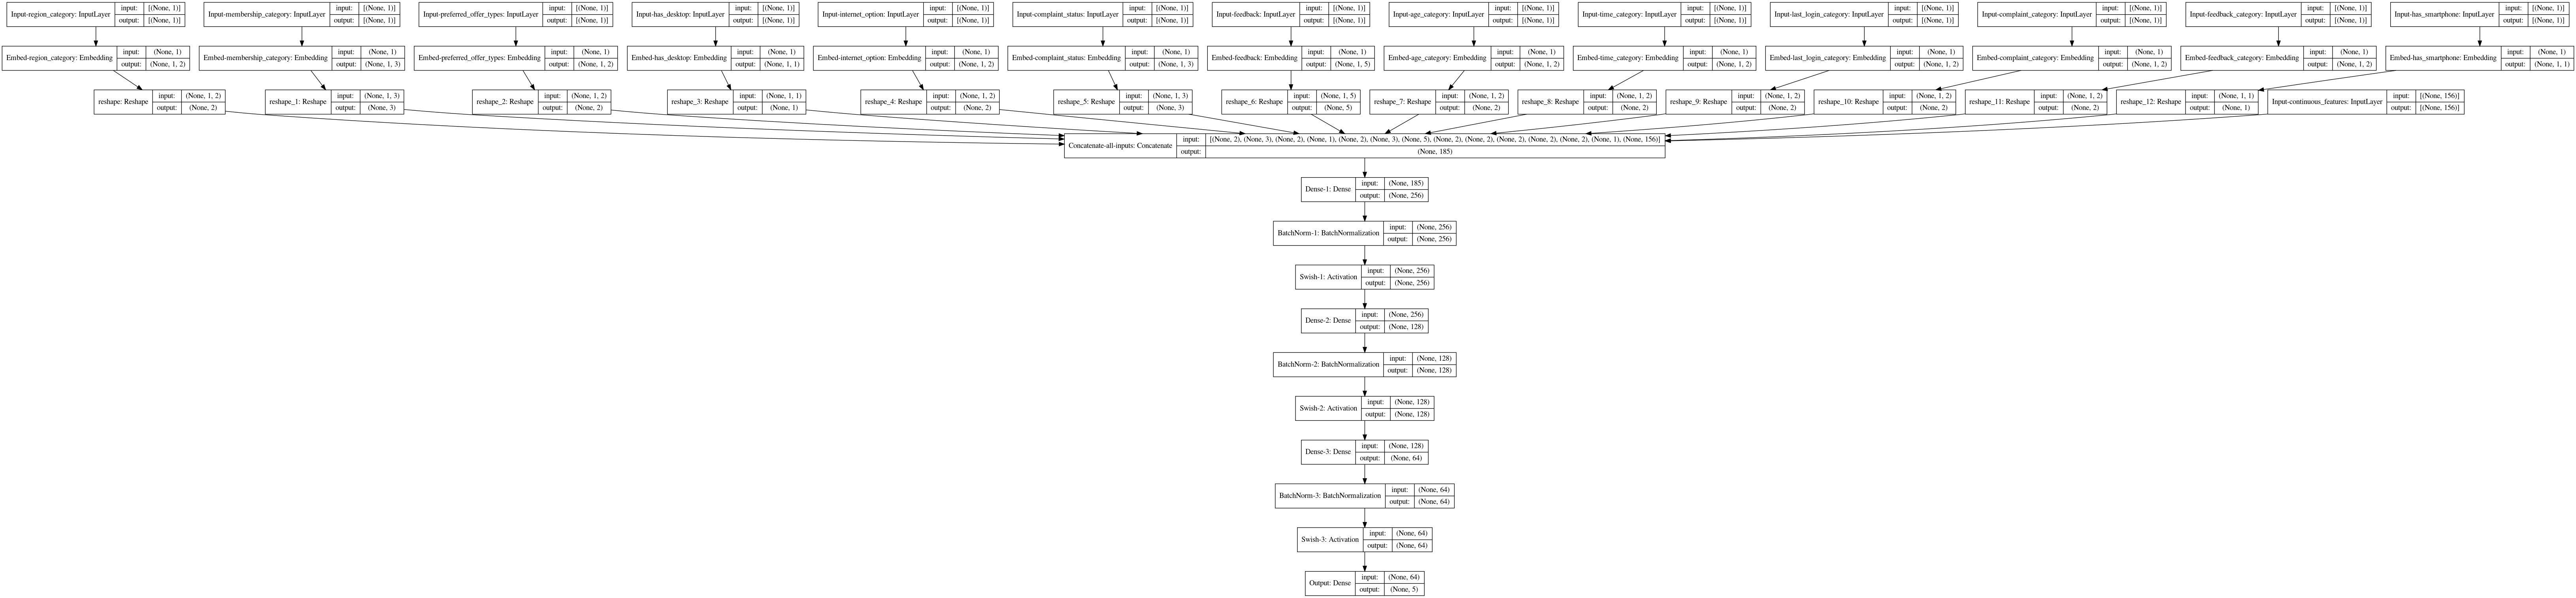

In [14]:
plot_model(
    model, to_file='./DNN_model.png', 
    show_shapes=True, show_layer_names=True
)

In [15]:
FOLD = 7
NUM_SEED = 3
VERBOSE = 0

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_dnn = np.zeros((train_df.shape[0], 5))
y_pred_final_dnn = np.zeros((Xtest15.shape[0], 5))
counter = 0
mini_batch_size = 128


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(train_df.loc[:, train_df.columns!='churn_risk_score'], train_df['churn_risk_score'])):
        counter += 1
        print(">>>>>>>>>>  Fold - {}  <<<<<<<<<<\n".format(counter))

        train_df1, val_df = train_df.iloc[train].copy(), train_df.iloc[val].copy()
        
        Xtrain1, Xval1 = np.array([train_df1['region_category'].values]).T, np.array([val_df['region_category'].values]).T
        Xtrain2, Xval2 = np.array([train_df1['membership_category'].values]).T, np.array([val_df['membership_category'].values]).T
        Xtrain3, Xval3 = np.array([train_df1['preferred_offer_types'].values]).T, np.array([val_df['preferred_offer_types'].values]).T
        Xtrain4, Xval4 = np.array([train_df1['has_desktop'].values]).T, np.array([val_df['has_desktop'].values]).T
        Xtrain5, Xval5 = np.array([train_df1['internet_option'].values]).T, np.array([val_df['internet_option'].values]).T
        Xtrain6, Xval6 = np.array([train_df1['complaint_status'].values]).T, np.array([val_df['complaint_status'].values]).T
        Xtrain7, Xval7 = np.array([train_df1['feedback'].values]).T, np.array([val_df['feedback'].values]).T
        Xtrain8, Xval8 = np.array([train_df1['age_category'].values]).T, np.array([val_df['age_category'].values]).T
        #Xtrain9, Xval9 = np.array([train_df1['joining_dt_year'].values]).T, np.array([val_df['joining_dt_year'].values]).T
        Xtrain10, Xval10 = np.array([train_df1['time_category'].values]).T, np.array([val_df['time_category'].values]).T
        Xtrain11, Xval11 = np.array([train_df1['last_login_category'].values]).T, np.array([val_df['last_login_category'].values]).T
        Xtrain12, Xval12 = np.array([train_df1['complaint_category'].values]).T, np.array([val_df['complaint_category'].values]).T
        Xtrain13, Xval13 = np.array([train_df1['feedback_category'].values]).T, np.array([val_df['feedback_category'].values]).T
        Xtrain14, Xval14 = np.array([train_df1['has_smartphone'].values]).T, np.array([val_df['has_smartphone'].values]).T
        
        Ytrain = np.array([train_df1['churn_risk_score'].values]).T
        Yval = np.array([val_df['churn_risk_score'].values]).T
        Ytrain = to_categorical(Ytrain, 5)
        Yval = to_categorical(Yval, 5)

        train_df1.drop(['region_category','membership_category','preferred_offer_types','has_desktop',
                        'internet_option','complaint_status','feedback','age_category',#'joining_dt_year',
                        'time_category','churn_risk_score','last_login_category','complaint_category',
                        'feedback_category','has_smartphone'], axis=1, inplace=True)

        val_df.drop(['region_category','membership_category','preferred_offer_types','has_desktop',
                     'internet_option','complaint_status','feedback','age_category',#'joining_dt_year',
                     'time_category','churn_risk_score','last_login_category','complaint_category',
                     'feedback_category','has_smartphone'], axis=1, inplace=True)

        Xtrain15, Xval15 = train_df1.values, val_df.values
        
        train_list = [Xtrain1, Xtrain2, Xtrain3, Xtrain4, Xtrain5, 
                      Xtrain6, Xtrain7, Xtrain8, Xtrain10, #Xtrain9, 
                      Xtrain11, Xtrain12, Xtrain13, Xtrain14, Xtrain15]
        
        val_list = [Xval1, Xval2, Xval3, Xval4, Xval5, Xval6, Xval7, Xval8, #Xval9, 
                    Xval10, Xval11, Xval12, Xval13, Xval14, Xval15]

        model = dnn_model(vocab_list)
        model.compile(loss='categorical_crossentropy',
                      metrics=[F1Score(num_classes=5, average='macro')],
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=7, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')
        
        history = model.fit(
            train_list, Ytrain, 
            batch_size=mini_batch_size,
            class_weight=class_weight, 
            epochs=150, 
            verbose=VERBOSE, 
            workers=5,
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=(val_list, Yval)
        )
        
        model = load_model('./DNN_model.h5')

        y_pred = model.predict(val_list)
        y_pred_bin = np.array([np.argmax(y_pred, axis=1)]).T
        y_true_bin = np.array([np.argmax(Yval, axis=1)]).T
        y_pred_meta_dnn[val] += y_pred
        y_pred_final_dnn += model.predict(test_list)
        
        score = 100 * f1_score(y_true_bin, y_pred_bin, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_dnn = y_pred_meta_dnn / float(NUM_SEED)
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

>>>>>>>>>>  Fold - 1  <<<<<<<<<<

Seed-24 | Fold-0 | OOF Score: 72.46791533715314
>>>>>>>>>>  Fold - 2  <<<<<<<<<<

Seed-24 | Fold-1 | OOF Score: 72.66624789564287
>>>>>>>>>>  Fold - 3  <<<<<<<<<<

Seed-24 | Fold-2 | OOF Score: 73.23543761800906
>>>>>>>>>>  Fold - 4  <<<<<<<<<<

Seed-24 | Fold-3 | OOF Score: 73.61780139646147
>>>>>>>>>>  Fold - 5  <<<<<<<<<<

Seed-24 | Fold-4 | OOF Score: 74.84219355541495
>>>>>>>>>>  Fold - 6  <<<<<<<<<<

Seed-24 | Fold-5 | OOF Score: 73.54052837917297
>>>>>>>>>>  Fold - 7  <<<<<<<<<<

Seed-24 | Fold-6 | OOF Score: 72.13626225082012

Seed: 24 | Aggregate OOF Score: 73.21519806181065


>>>>>>>>>>  Fold - 8  <<<<<<<<<<

Seed-3 | Fold-0 | OOF Score: 75.47711279691585
>>>>>>>>>>  Fold - 9  <<<<<<<<<<

Seed-3 | Fold-1 | OOF Score: 72.95982060536734
>>>>>>>>>>  Fold - 10  <<<<<<<<<<

Seed-3 | Fold-2 | OOF Score: 72.74950255369058
>>>>>>>>>>  Fold - 11  <<<<<<<<<<

Seed-3 | Fold-3 | OOF Score: 72.82482965391004
>>>>>>>>>>  Fold - 12  <<<<<<<<<<

Seed-3 | Fol

In [16]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [17]:
test_df = pd.read_csv("../input/customer-churn-rate-prediction/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['customer_id'] = test_df['customer_id']
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_dnn, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [18]:
submit_df.to_csv("./DNN_submission.csv", index=False)